In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import pyepo
import torch
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)
from sklearn.model_selection import train_test_split

Auto-Sklearn cannot be imported.


In [3]:
# linear model
class LinearRegression(nn.Module):
    
    def __init__(self, indim, outdim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(indim, outdim)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [4]:
def train(optmodel, reg, trainloader, testloader, lr, caption, num_epochs=300, lambd=20):
    # cuda
    if torch.cuda.is_available():
        reg = reg.cuda()
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set dbb optimizer
    bb = pyepo.func.blackboxOpt(optmodel, lambd=lambd, processes=4)
    # set loss
    criterion = nn.L1Loss()
    # train model
    reg.train()
    loss_log = []
    grad_log = []
    loss_log_truespo = []
    loss_log_unambspo = []
    for epoch in range(num_epochs):
        # load data
        for i, data in enumerate(trainloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # linear regression
            cp = reg(x)
            # black-box optimizer
            wp = bb.apply(cp)
            # loss
            loss = criterion(wp, w)
            # add hook
            abs_grad = []
            cp.register_hook(lambda grad: abs_grad.append(torch.abs(grad).mean().item()))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_log.append(loss.item())
        grad_log.append(abs_grad[0])
        if (epoch + 1) % 5 == 0:
            # true SPO
            trueloss = pyepo.metric.regret(reg, optmodel, testloader)
            loss_log_truespo.append(trueloss)
            # unambiguous SPO 
            unambloss = pyepo.metric.unambRegret(reg, optmodel, testloader)
            loss_log_unambspo.append(unambloss)
            print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
                  format(epoch+1, loss.item(), trueloss*100, unambloss*100))
    drawplot(num_epochs, grad_log, loss_log, loss_log_truespo, loss_log_unambspo, caption)

In [5]:
def drawplot(num_epochs, grad_log, loss_log, loss_log_truespo, loss_log_unambspo, caption):
    # loss
    fig = plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title(caption, fontsize=36)
    plt.show()
    # abs grad
    fig = plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="c", lw=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title(caption, fontsize=36)
    plt.show()
    # regret
    fig = plt.figure(figsize=(16, 8))
    plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--",
             alpha=0.7, lw=5, label="Regret")
    plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":",
             alpha=0.7, lw=6, label="Unambiguous Regret")
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title(caption, fontsize=36)
    plt.legend(fontsize=32)
    plt.show()
    if caption == "Shortest Path":
        fig.savefig("./images/hamming-sp.pdf", dpi=300)
    if caption == "2D Knapsack":
        fig.savefig("./images/hamming-ks2.pdf", dpi=300)
    if caption == "Travelling Salesman":
        fig.savefig("./images/hamming-tsp.pdf", dpi=300)

## Shortest Path

In [6]:
# init data
grid = (5,5) # grid graph
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise half-width
x, c = pyepo.data.shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e)

In [7]:
# optimization model 
sp_model = pyepo.model.grb.shortestPathModel(grid)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-05


In [8]:
# prediction model
reg = LinearRegression(p, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

In [9]:
# dataset
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)
sp_dataset_train = pyepo.data.dataset.optDataset(sp_model, x_train, c_train)
sp_dataset_test = pyepo.data.dataset.optDataset(sp_model, x_test, c_test)
# data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1042.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1090.27it/s]


Num of cores: 4
Epoch   5, Loss:   0.2562, Regret: 39.2401%, Unambiguous Regret: 39.2401%
Epoch  10, Loss:   0.2562, Regret: 31.2239%, Unambiguous Regret: 31.2239%
Epoch  15, Loss:   0.2188, Regret: 22.3715%, Unambiguous Regret: 22.3715%
Epoch  20, Loss:   0.2250, Regret: 19.9123%, Unambiguous Regret: 19.9123%
Epoch  25, Loss:   0.1375, Regret: 18.0609%, Unambiguous Regret: 18.0609%
Epoch  30, Loss:   0.2250, Regret: 17.5672%, Unambiguous Regret: 17.5672%
Epoch  35, Loss:   0.1875, Regret: 14.9767%, Unambiguous Regret: 14.9768%
Epoch  40, Loss:   0.1250, Regret: 14.5563%, Unambiguous Regret: 14.5563%
Epoch  45, Loss:   0.1688, Regret: 15.0525%, Unambiguous Regret: 15.0525%
Epoch  50, Loss:   0.1875, Regret: 14.5921%, Unambiguous Regret: 14.5922%
Epoch  55, Loss:   0.1063, Regret: 13.3971%, Unambiguous Regret: 13.3971%
Epoch  60, Loss:   0.1625, Regret: 13.5956%, Unambiguous Regret: 13.5956%
Epoch  65, Loss:   0.1562, Regret: 12.8655%, Unambiguous Regret: 12.8655%
Epoch  70, Loss:   0.1

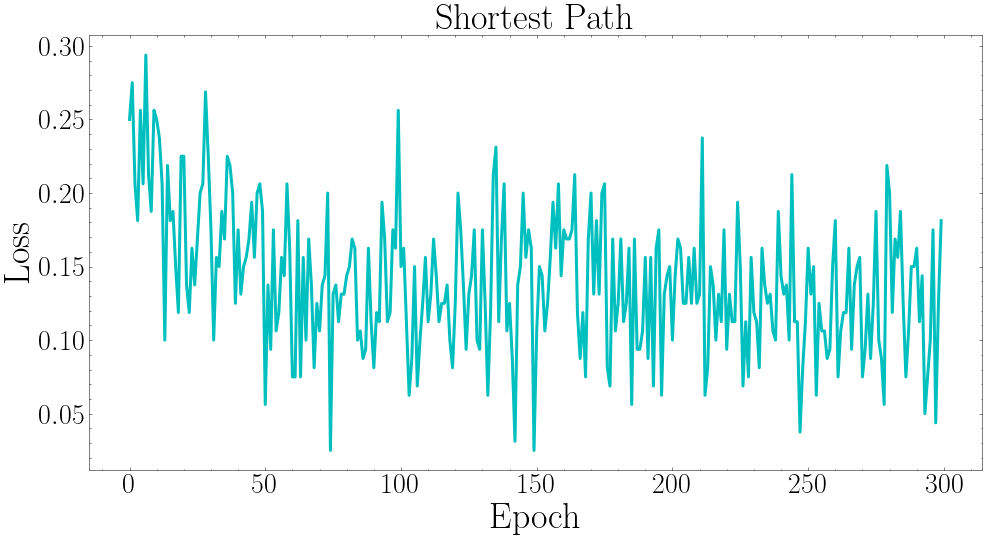

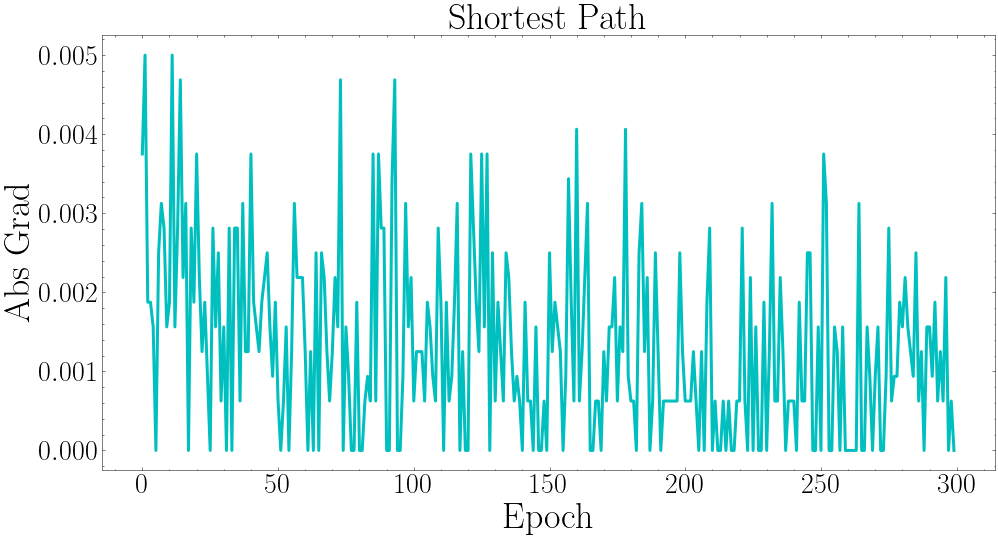

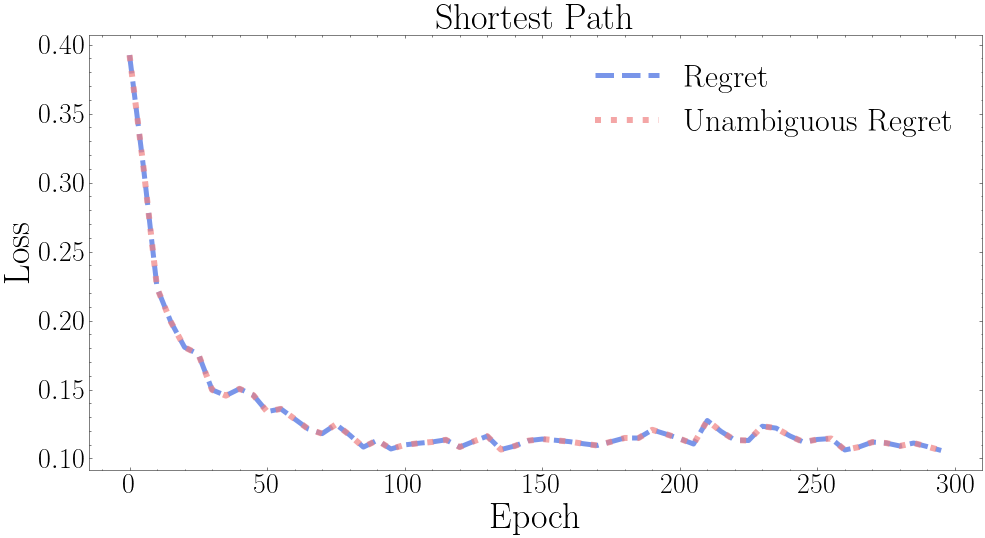

In [10]:
train(sp_model, reg, sp_loader_train, sp_loader_test, lr=5e-3, caption="Shortest Path")

## 2D Knapsack

In [11]:
# init data
m = 48 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [30] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim, noise_width=noise_width)

In [12]:
# optimization model 
ks_model = pyepo.model.grb.knapsackModel(weights, caps)

In [13]:
# prediction model
reg = LinearRegression(p, m)

In [14]:
# dataset
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)
ks_dataset_train = pyepo.data.dataset.optDataset(ks_model, x_train, c_train)
ks_dataset_test = pyepo.data.dataset.optDataset(ks_model, x_test, c_test)
# data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 294.05it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.14it/s]


Num of cores: 4
Epoch   5, Loss:   0.2344, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  10, Loss:   0.2292, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  15, Loss:   0.2188, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  20, Loss:   0.2188, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  25, Loss:   0.2188, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  30, Loss:   0.2240, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  35, Loss:   0.2031, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  40, Loss:   0.1927, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  45, Loss:   0.2083, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  50, Loss:   0.2240, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  55, Loss:   0.2500, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  60, Loss:   0.2135, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  65, Loss:   0.2240, Regret: 55.7185%, Unambiguous Regret: 55.7185%
Epoch  70, Loss:   0.2

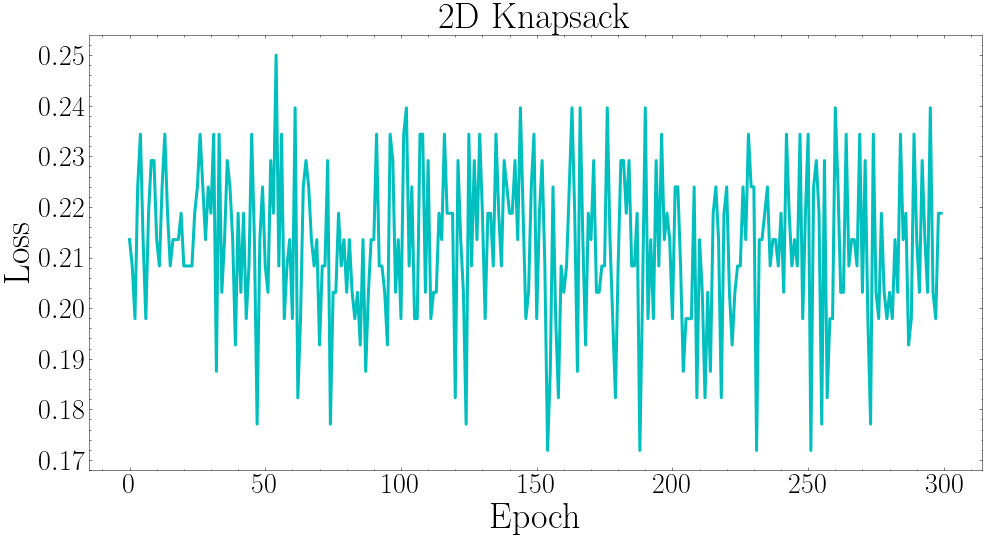

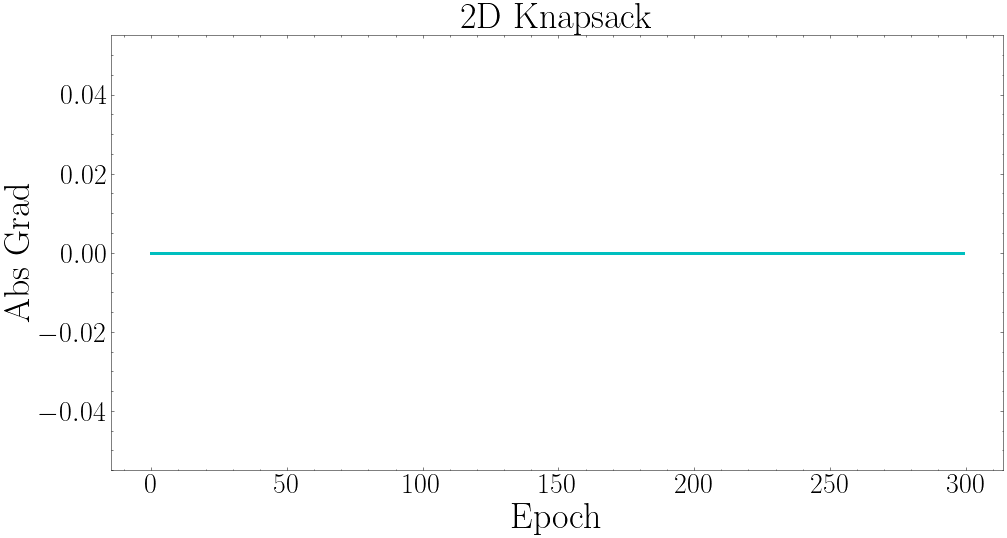

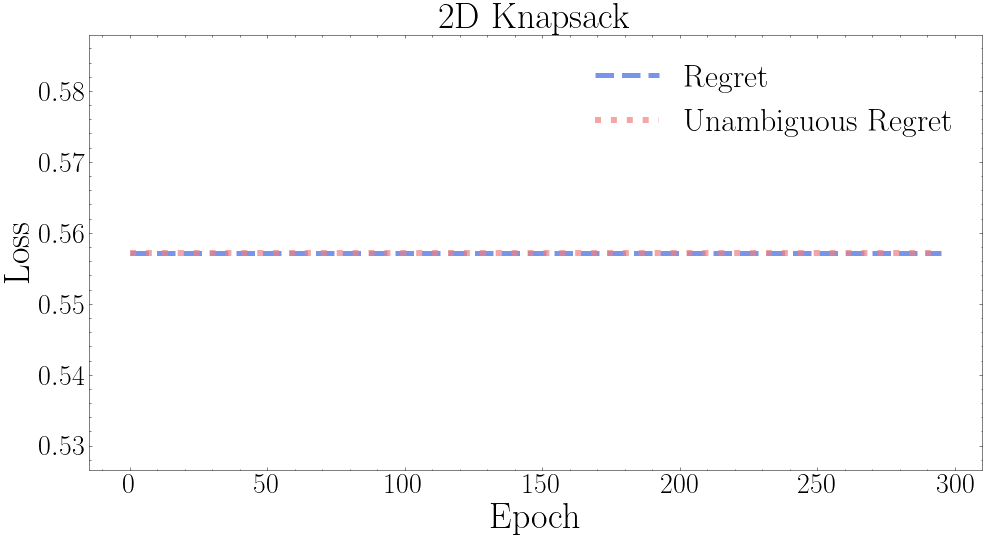

In [15]:
train(ks_model, reg, ks_loader_train, ks_loader_test, lr=1e-2, caption="2D Knapsack")

## TSP 

In [16]:
# init data
m = 20 # number of nodes
n = 1000 # number of data
p = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise half-width
x, c = pyepo.data.tsp.genData(n+1000, p, m, deg=deg, noise_width=e)

In [17]:
# optimization model 
tsp_model = pyepo.model.grb.tspDFJModel(m)

In [18]:
# prediction model
reg = LinearRegression(p, m*(m-1)//2)

In [19]:
# dataset
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)
tsp_dataset_train = pyepo.data.dataset.optDataset(tsp_model, x_train, c_train)
tsp_dataset_test = pyepo.data.dataset.optDataset(tsp_model, x_test, c_test)
# data loader
batch_size = 32
tsp_loader_train = DataLoader(tsp_dataset_train, batch_size=batch_size, shuffle=True)
tsp_loader_test = DataLoader(tsp_dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.70it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.80it/s]


Num of cores: 4
Epoch   5, Loss:   0.1829, Regret: 172.6373%, Unambiguous Regret: 172.6516%
Epoch  10, Loss:   0.1763, Regret: 161.5396%, Unambiguous Regret: 161.5396%
Epoch  15, Loss:   0.1750, Regret: 159.5920%, Unambiguous Regret: 159.5920%
Epoch  20, Loss:   0.1842, Regret: 151.4714%, Unambiguous Regret: 151.4714%
Epoch  25, Loss:   0.1750, Regret: 147.7664%, Unambiguous Regret: 147.7712%
Epoch  30, Loss:   0.1724, Regret: 144.8157%, Unambiguous Regret: 144.8157%
Epoch  35, Loss:   0.1684, Regret: 143.3934%, Unambiguous Regret: 143.3934%
Epoch  40, Loss:   0.1658, Regret: 142.5368%, Unambiguous Regret: 142.5368%
Epoch  45, Loss:   0.1671, Regret: 138.4154%, Unambiguous Regret: 138.4126%
Epoch  50, Loss:   0.1632, Regret: 134.1493%, Unambiguous Regret: 134.1493%
Epoch  55, Loss:   0.1605, Regret: 129.0786%, Unambiguous Regret: 129.1113%
Epoch  60, Loss:   0.1658, Regret: 124.0477%, Unambiguous Regret: 124.0477%
Epoch  65, Loss:   0.1579, Regret: 126.6815%, Unambiguous Regret: 126.68

Epoch 555, Loss:   0.1289, Regret: 80.1342%, Unambiguous Regret: 80.1342%
Epoch 560, Loss:   0.1434, Regret: 79.2288%, Unambiguous Regret: 79.2429%
Epoch 565, Loss:   0.1355, Regret: 78.3897%, Unambiguous Regret: 78.3897%
Epoch 570, Loss:   0.1316, Regret: 77.7113%, Unambiguous Regret: 77.7302%
Epoch 575, Loss:   0.1461, Regret: 77.7361%, Unambiguous Regret: 77.7488%
Epoch 580, Loss:   0.1355, Regret: 76.9593%, Unambiguous Regret: 76.9174%
Epoch 585, Loss:   0.1329, Regret: 76.8928%, Unambiguous Regret: 76.8655%
Epoch 590, Loss:   0.1158, Regret: 77.5913%, Unambiguous Regret: 77.5913%
Epoch 595, Loss:   0.1408, Regret: 77.7395%, Unambiguous Regret: 77.7395%
Epoch 600, Loss:   0.1289, Regret: 76.6969%, Unambiguous Regret: 76.6969%
Epoch 605, Loss:   0.1289, Regret: 76.7735%, Unambiguous Regret: 76.7735%
Epoch 610, Loss:   0.1368, Regret: 76.9690%, Unambiguous Regret: 76.9721%
Epoch 615, Loss:   0.1263, Regret: 76.2699%, Unambiguous Regret: 76.2262%
Epoch 620, Loss:   0.1250, Regret: 75.

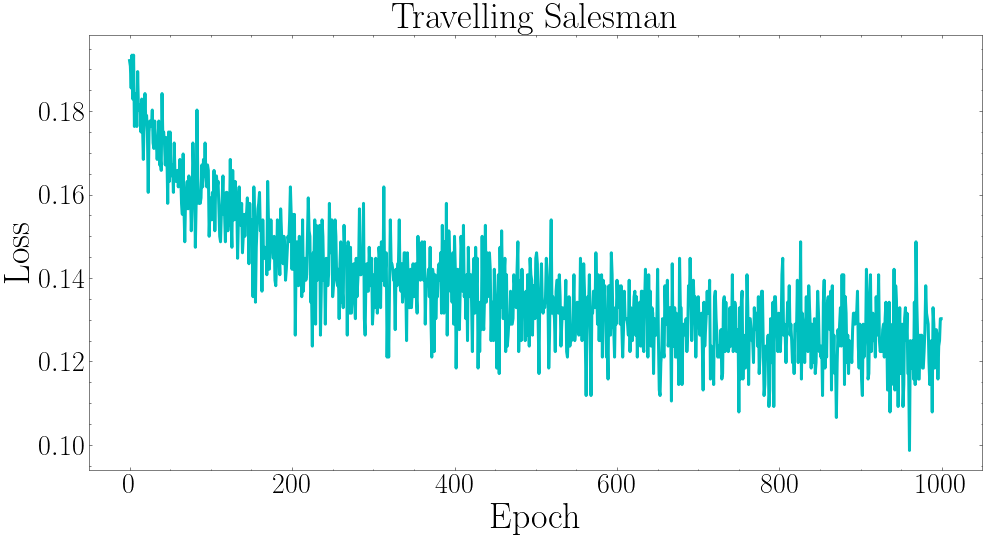

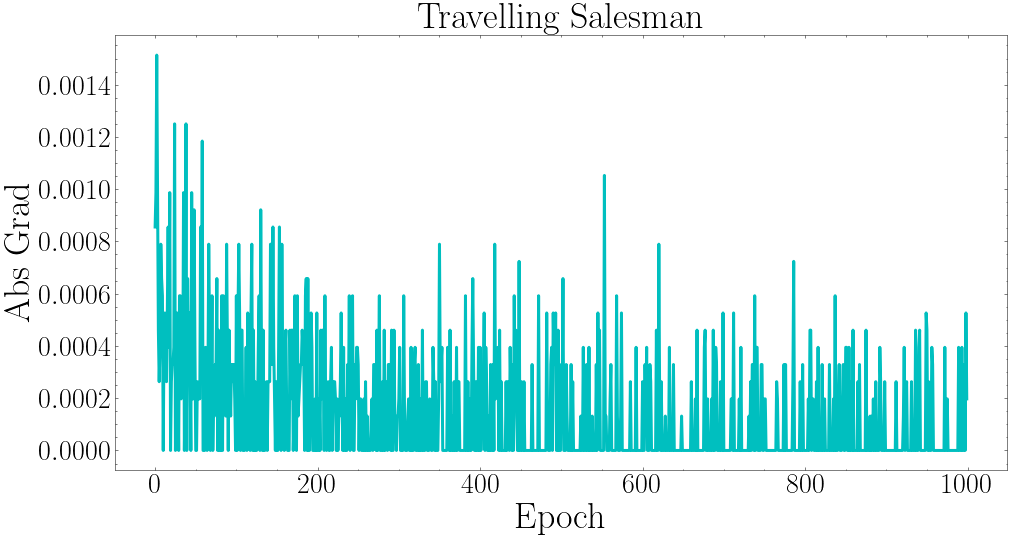

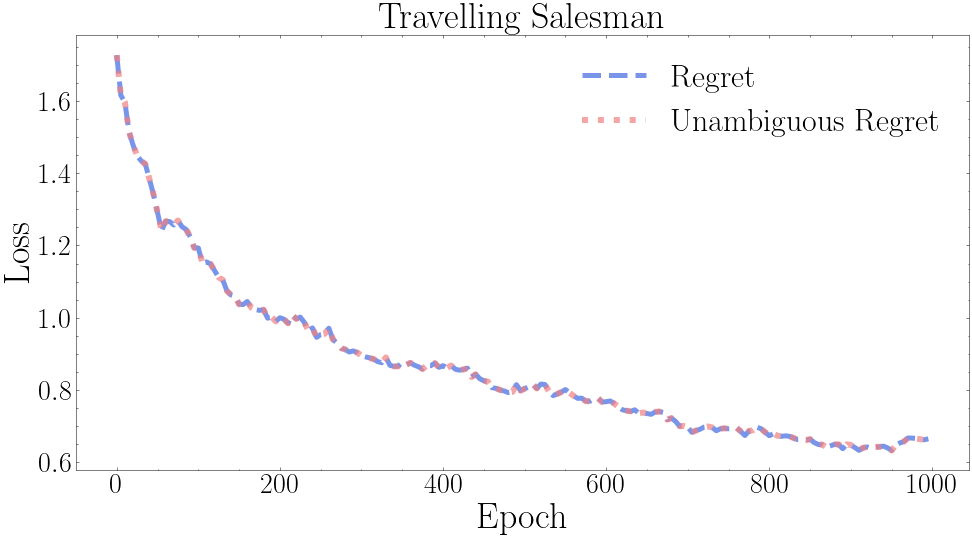

In [20]:
train(tsp_model, reg, tsp_loader_train, tsp_loader_test, lr=1e-2, num_epochs=1000, caption="Travelling Salesman")